## 16.2 複数のモデルを比較する
### 16.2.1 線形モデルの比較

### データを読み込む

In [39]:
import polars as pl

housing = pl.read_csv("../data/housing_renamed.csv")
housing.head()

neighborhood,type,units,year_built,sq_ft,income,income_per_sq_ft,expense,expense_per_sq_ft,net_income,value,value_per_sq_ft,boro
str,str,i64,f64,i64,i64,f64,i64,f64,i64,i64,f64,str
"""FINANCIAL""","""R9-CONDOMINIUM…",42,1920.0,36500,1332615,36.51,342005,9.37,990610,7300000,200.0,"""Manhattan"""
"""FINANCIAL""","""R4-CONDOMINIUM…",78,1985.0,126420,6633257,52.47,1762295,13.94,4870962,30690000,242.76,"""Manhattan"""
"""FINANCIAL""","""RR-CONDOMINIUM…",500,null,554174,17310000,31.24,3543000,6.39,13767000,90970000,164.15,"""Manhattan"""
"""FINANCIAL""","""R4-CONDOMINIUM…",282,1930.0,249076,11776313,47.28,2784670,11.18,8991643,67556006,271.23,"""Manhattan"""
"""TRIBECA""","""R4-CONDOMINIUM…",239,1985.0,219495,10004582,45.58,2783197,12.68,7221385,54320996,247.48,"""Manhattan"""


### 各モデルの学習

In [40]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [41]:
f1 = "value_per_sq_ft ~ units + sq_ft + boro"
f2 = "value_per_sq_ft ~ units * sq_ft + boro"
f3 = "value_per_sq_ft ~ units + sq_ft * boro + type"
f4 = "value_per_sq_ft ~ units + sq_ft * boro + sq_ft * type"
f5 = "value_per_sq_ft ~ boro + type"

house1 = smf.ols(f1, data = housing).fit()
house2 = smf.ols(f2, data = housing).fit()
house3 = smf.ols(f3, data = housing).fit()
house4 = smf.ols(f4, data = housing).fit()
house5 = smf.ols(f5, data = housing).fit()

In [42]:
house1.params

Intercept                 43.290863
boro[T.Brooklyn]          34.562150
boro[T.Manhattan]        130.992363
boro[T.Queens]            32.993674
boro[T.Staten Island]     -3.630251
units                     -0.188115
sq_ft                      0.000210
dtype: float64

In [43]:
house1.params.index.tolist()

['Intercept',
 'boro[T.Brooklyn]',
 'boro[T.Manhattan]',
 'boro[T.Queens]',
 'boro[T.Staten Island]',
 'units',
 'sq_ft']

In [44]:
# 長さの異なるデータを横に結合したい場合は、pandasの方が簡単
import pandas as pd

mod_results = (
    pd.concat([
        house1.params,
        house2.params,
        house3.params,
        house4.params,
        house5.params
    ],
    axis = 1)
    .rename(columns = lambda col: "house" + str(col + 1))
    .reset_index()
    .rename(columns = {"index": "param"})
    .melt(id_vars = "param", var_name = "model", value_name = "estimate")
)
mod_results

,param,model,estimate
0,Intercept,house1,43.290863
1,boro[T.Brooklyn],house1,34.562150
2,boro[T.Manhattan],house1,130.992363
3,boro[T.Queens],house1,32.993674
4,boro[T.Staten Island],house1,-3.630251
...,...,...,...
85,sq_ft:boro[T.Queens],house5,NaN
86,sq_ft:boro[T.Staten Island],house5,NaN
87,sq_ft:type[T.R4-CONDOMINIUM],house5,NaN
88,sq_ft:type[T.R9-CONDOMINIUM],house5,NaN


### モデル毎の残差を可視化する

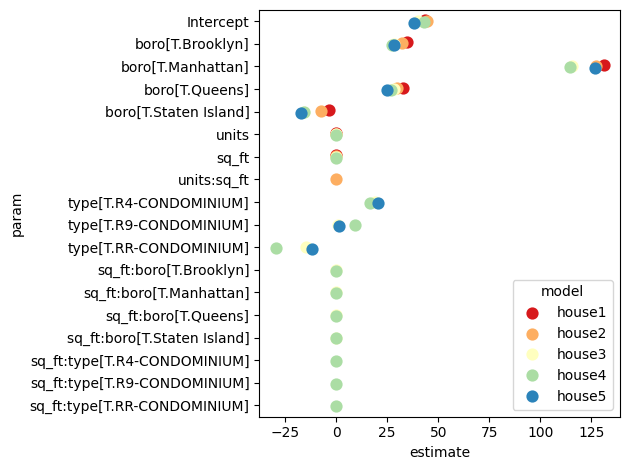

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# 層毎の色分け
color_dict = dict(
    {
        "house1": "#d7191c",
        "house2": "#fdae61",
        "house3": "#ffffbf",
        "house4": "#abdda4",
        "house5": "#2b83ba",
    }
)

fig, ax = plt.subplots()
ax = sns.pointplot(
    x = "estimate",
    y = "param",
    hue = "model",
    data = mod_results,
    dodge = True,
    linestyle = 'none',
    palette = color_dict,
)

plt.tight_layout()
plt.show()

### ANOVAを用いて、モデルを評価する

In [46]:
model_names = ["house1", "house2", "house3", "house4", "house5"]
house_anova = statsmodels.stats.anova.anova_lm(
    house1, house2, house3, house4, house5
)

house_anova.index = model_names

house_anova

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
house1,2619.0,4.922389e+06,0.0,NaN,NaN,NaN
house2,2618.0,4.884872e+06,1.0,37517.437605,20.039049,7.912333e-06
house3,2612.0,4.619926e+06,6.0,264945.539994,23.585728,2.754431e-27
house4,2609.0,4.576671e+06,3.0,43255.441192,7.701289,4.025581e-05
house5,2618.0,4.901463e+06,-9.0,-324791.847907,19.275539,NaN


### AICを用いてモデルを評価する

In [47]:
house_models = [house1, house2, house3, house4, house5]

abic = pd.DataFrame({
    "model": model_names,
    "aic": [mod.aic for mod in house_models],
    "bic": [mod.bic for mod in house_models]
})

abic.sort_values(by = ["aic", "bic"])

,model,aic,bic
3,house4,27084.800043,27184.644733
2,house3,27103.502577,27185.727615
1,house2,27237.939618,27284.925354
4,house5,27246.843392,27293.829128
0,house1,27256.031113,27297.143632
